In [18]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm
from pathlib import Path

In [19]:
pd.set_option("display.max_rows", 500)

# Import datasets

In [20]:
%%time

datasets = {
    'AmpC': r'/storage/margaritakovaleva/2021-06-15_big_datasets/AmpC_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'D4': r'/storage/margaritakovaleva/2021-06-15_big_datasets/D4_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'CB2': '/storage/margaritakovaleva/2022-07-22_tables/5zty/result_single_Morgan_size=2048_radius=2.csv',
    'AA2AR': '/storage/margaritakovaleva/2022-07-22_tables/4eiy/result_single_Morgan_size=2048_radius=2.csv'
}
dataset_size = {'AmpC': 96214206, 'D4': 138312677,
                'AA2AR': int(1e6), 'CB2': int(1e6)}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)


  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 34.6 ms, sys: 10.6 ms, total: 45.1 ms
Wall time: 42 ms


# Convert types and select necessary subframe

In [21]:
def threshold_to_int(df: pd.DataFrame) -> pd.DataFrame:
    def threshold2int(s):
        return float(s.replace("%", " ").split()[1])

    df["top_threshold"] = df.apply({"top_threshold": threshold2int})
    return df


In [22]:
df = (
    raw_data.drop("Unnamed: 0", axis=1)
    .pipe(threshold_to_int)
    .dropna(axis=1)
    .rename({"type": "model_type"}, axis=1)
    .query('model_type == "regressor"')
    .query("top_threshold == 1")
    .query("train_size != 20_000")
    .query("train_size != 10_000")
    .reset_index()
    .drop(
        [
            "model_type",
            "top_threshold",
            "accuracy_score",
            "precision_score",
            "TP+FP",
            "fingerprints",
        ],
        axis=1,
    )
)

In [23]:
df.sample(10)

,index,model,train_size,recall_score,docked,time_sec,proj,N_ligands
592,1087,Ridge,160000,0.04750,160400,63,CB2,1000000
689,1446,RidgeCV,80000,0.05000,80200,52,CB2,1000000
444,493,WeightedLinearRegressionScale50,160000,0.00500,160400,34,CB2,1000000
939,1628,DecisionTreeRegressor,80000,0.03500,80200,112,AA2AR,1000000
435,462,WeightedLinearRegressionScale10,320000,0.01250,320800,60,CB2,1000000
479,640,WeightedLinearRegressionScale50,320000,0.01125,320800,59,CB2,1000000
659,1331,LassoCV,8000,0.15000,8020,74,CB2,1000000
1012,1911,KNeighborsRegressorWithOneNeighbor,40000,0.06000,40100,1017,AA2AR,1000000
974,1779,LassoCV,80000,0.13000,80200,4045,AA2AR,1000000
2,418,LassoCV,40000,0.34000,40100,506,AmpC,96214206


# Manually filter regressors we're not gonna use

In [24]:
# print all good regressors

available_regressors = []

for proj in df.proj.unique():
    agg = (
        df.query(f'proj=="{proj}"')
        .groupby(["train_size", "proj", "model"], as_index=False)
        .agg("count")
    )
    available_regressors.extend(agg.query("index == 5").model.unique())

available_regressors = list(set(available_regressors))
print(*sorted(available_regressors), sep="\n")

DecisionTreeRegressor
DockingAsPredictor
DummyRegressor
KNeighborsRegressor
KNeighborsRegressorWithOneNeighbor
KNeighborsRegressorWithOneNeighborJaccard
Lasso
LassoCV
LinearRegression
LinearSVR
RandomForestRegressor
RandomGaussianRegressor
RandomUniformRegressor
Ridge
RidgeCV
SVR
WeightedLinearRegressionScale10
WeightedLinearRegressionScale100
WeightedLinearRegressionScale20
WeightedLinearRegressionScale50


In [25]:
interesting_regressors = """
RandomGaussianRegressor
#DockingAsPredictor
LinearRegression
Lasso
LassoCV
Ridge
RidgeCV
SVR
LinearSVR
KNeighborsRegressor
#KNeighborsRegressorWithOneNeighbor
#KNeighborsRegressorWithOneNeighborJaccard
DecisionTreeRegressor
RandomForestRegressor
#RandomUniformRegressor
#DummyRegressor
#WeightedLinearRegressionScale10
#WeightedLinearRegressionScale100
#WeightedLinearRegressionScale20
#WeightedLinearRegressionScale50
""".split()
interesting_regressors = [s for s in interesting_regressors if not s.startswith("#")]

In [26]:
## this version will give me only those regressors that are good within one fold
# available_regressors = []
# 
# cols = ["train_size", "proj", "model"]
# agg = df.groupby(cols).agg({"index": "count"})
# agg.columns = ["n_folds"]

## this is good for getting models that don't have missing values for all folds
cols = ["proj", "model"]
agg = df.groupby(cols).agg({"index": "count"})
agg.columns = ["n_folds"]

In [27]:
row_order = ["AA2AR", "CB2", "AmpC", "D4"]
df_p = (
    df.query("model in @interesting_regressors")
    .merge(agg, left_on=cols, right_index=True, suffixes=("", "_agg"))
    .query("n_folds == 25")
    .sort_values("model", key=lambda x: x.map(interesting_regressors.index))
    .sort_values("proj", key=lambda x: x.map(row_order.index))
    .reset_index()
    .drop(["level_0", "index", "n_folds"], axis=1)
    .assign(row_order=lambda x: x.index)
)


## Print regressors for each project

In [28]:
for proj in df_p.proj.unique():
    print(f"{proj=}")
    agg = (
        df_p.query(f'proj=="{proj}"')
        .groupby(["proj", "model"], as_index=False)
        .agg("count")
    )
    print(*["\t" + s for s in agg.model.unique()], sep="\n")

proj='AA2AR'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	LinearSVR
	RandomGaussianRegressor
	Ridge
proj='CB2'
	Lasso
	LassoCV
	LinearRegression
	LinearSVR
	RandomForestRegressor
	RandomGaussianRegressor
	Ridge
	RidgeCV
proj='AmpC'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	RidgeCV
proj='D4'
	DecisionTreeRegressor
	KNeighborsRegressor
	LassoCV
	LinearRegression
	RandomForestRegressor
	RidgeCV


# Do the actual plotting

In [29]:
df = df.query("train_size != 320_000")
cols = ["proj", "model"]
agg = df.groupby(cols).agg({"index": "count"})
agg.columns = ["n_folds"]

In [30]:
rename = '''
DockingAsPredictor = Dock
LinearSVR = LinSVR
LinearRegression = LinReg
DecisionTreeRegressor = DT
KNeighborsRegressor = KNN
LassoCV = LassoCV
RandomGaussianRegressor = random
Ridge = Ridge
RandomForestRegressor = RF
RidgeCV = RidgeCV
Lasso = Lasso
SVR = SVR
'''
rename = {elem.split('=')[0].strip(): elem.split(
    '=')[1].strip() for elem in rename.split('\n')
    if elem}

def replace_model_name(df: pd.DataFrame) -> pd.DataFrame:
    df['model'] = df.model.replace(rename)
    return df

In [31]:
row_order = ["AA2AR", "CB2", "AmpC", "D4"]
df_p = (df
    .query("model in @interesting_regressors")
    .merge(agg, left_on=cols, right_index=True, suffixes=("", "_agg"))
    .query("n_folds == 20")
    .sort_values("model", key=lambda x: x.map(interesting_regressors.index))
    .sort_values("proj", key=lambda x: x.map(row_order.index))
    .reset_index()
    .drop(["level_0", "index", "n_folds"], axis=1)
    .assign(row_order=lambda x: x.index)
    .pipe(replace_model_name)
    .rename({'recall_score':'recall'}, axis=1)
)


## Rename models to improve readability

In [32]:
def ordered_stripplot(*args, **kwargs):
    # modified from https://stackoverflow.com/questions/46465368/order-of-categoricals-in-seaborn-pairgrid
    # and https://stackoverflow.com/questions/29968097/seaborn-facetgrid-user-defined-plot-function
    order = kwargs.pop("order")
    data = kwargs['data']
    proj = data.proj.unique()[0]
    order = order[proj]
    sns.stripplot(x=kwargs.pop('x'), y=kwargs.pop('y'), order=order, **kwargs)

In [33]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

Saved figure to fout='../figures/Figure_4_execution_time.png'


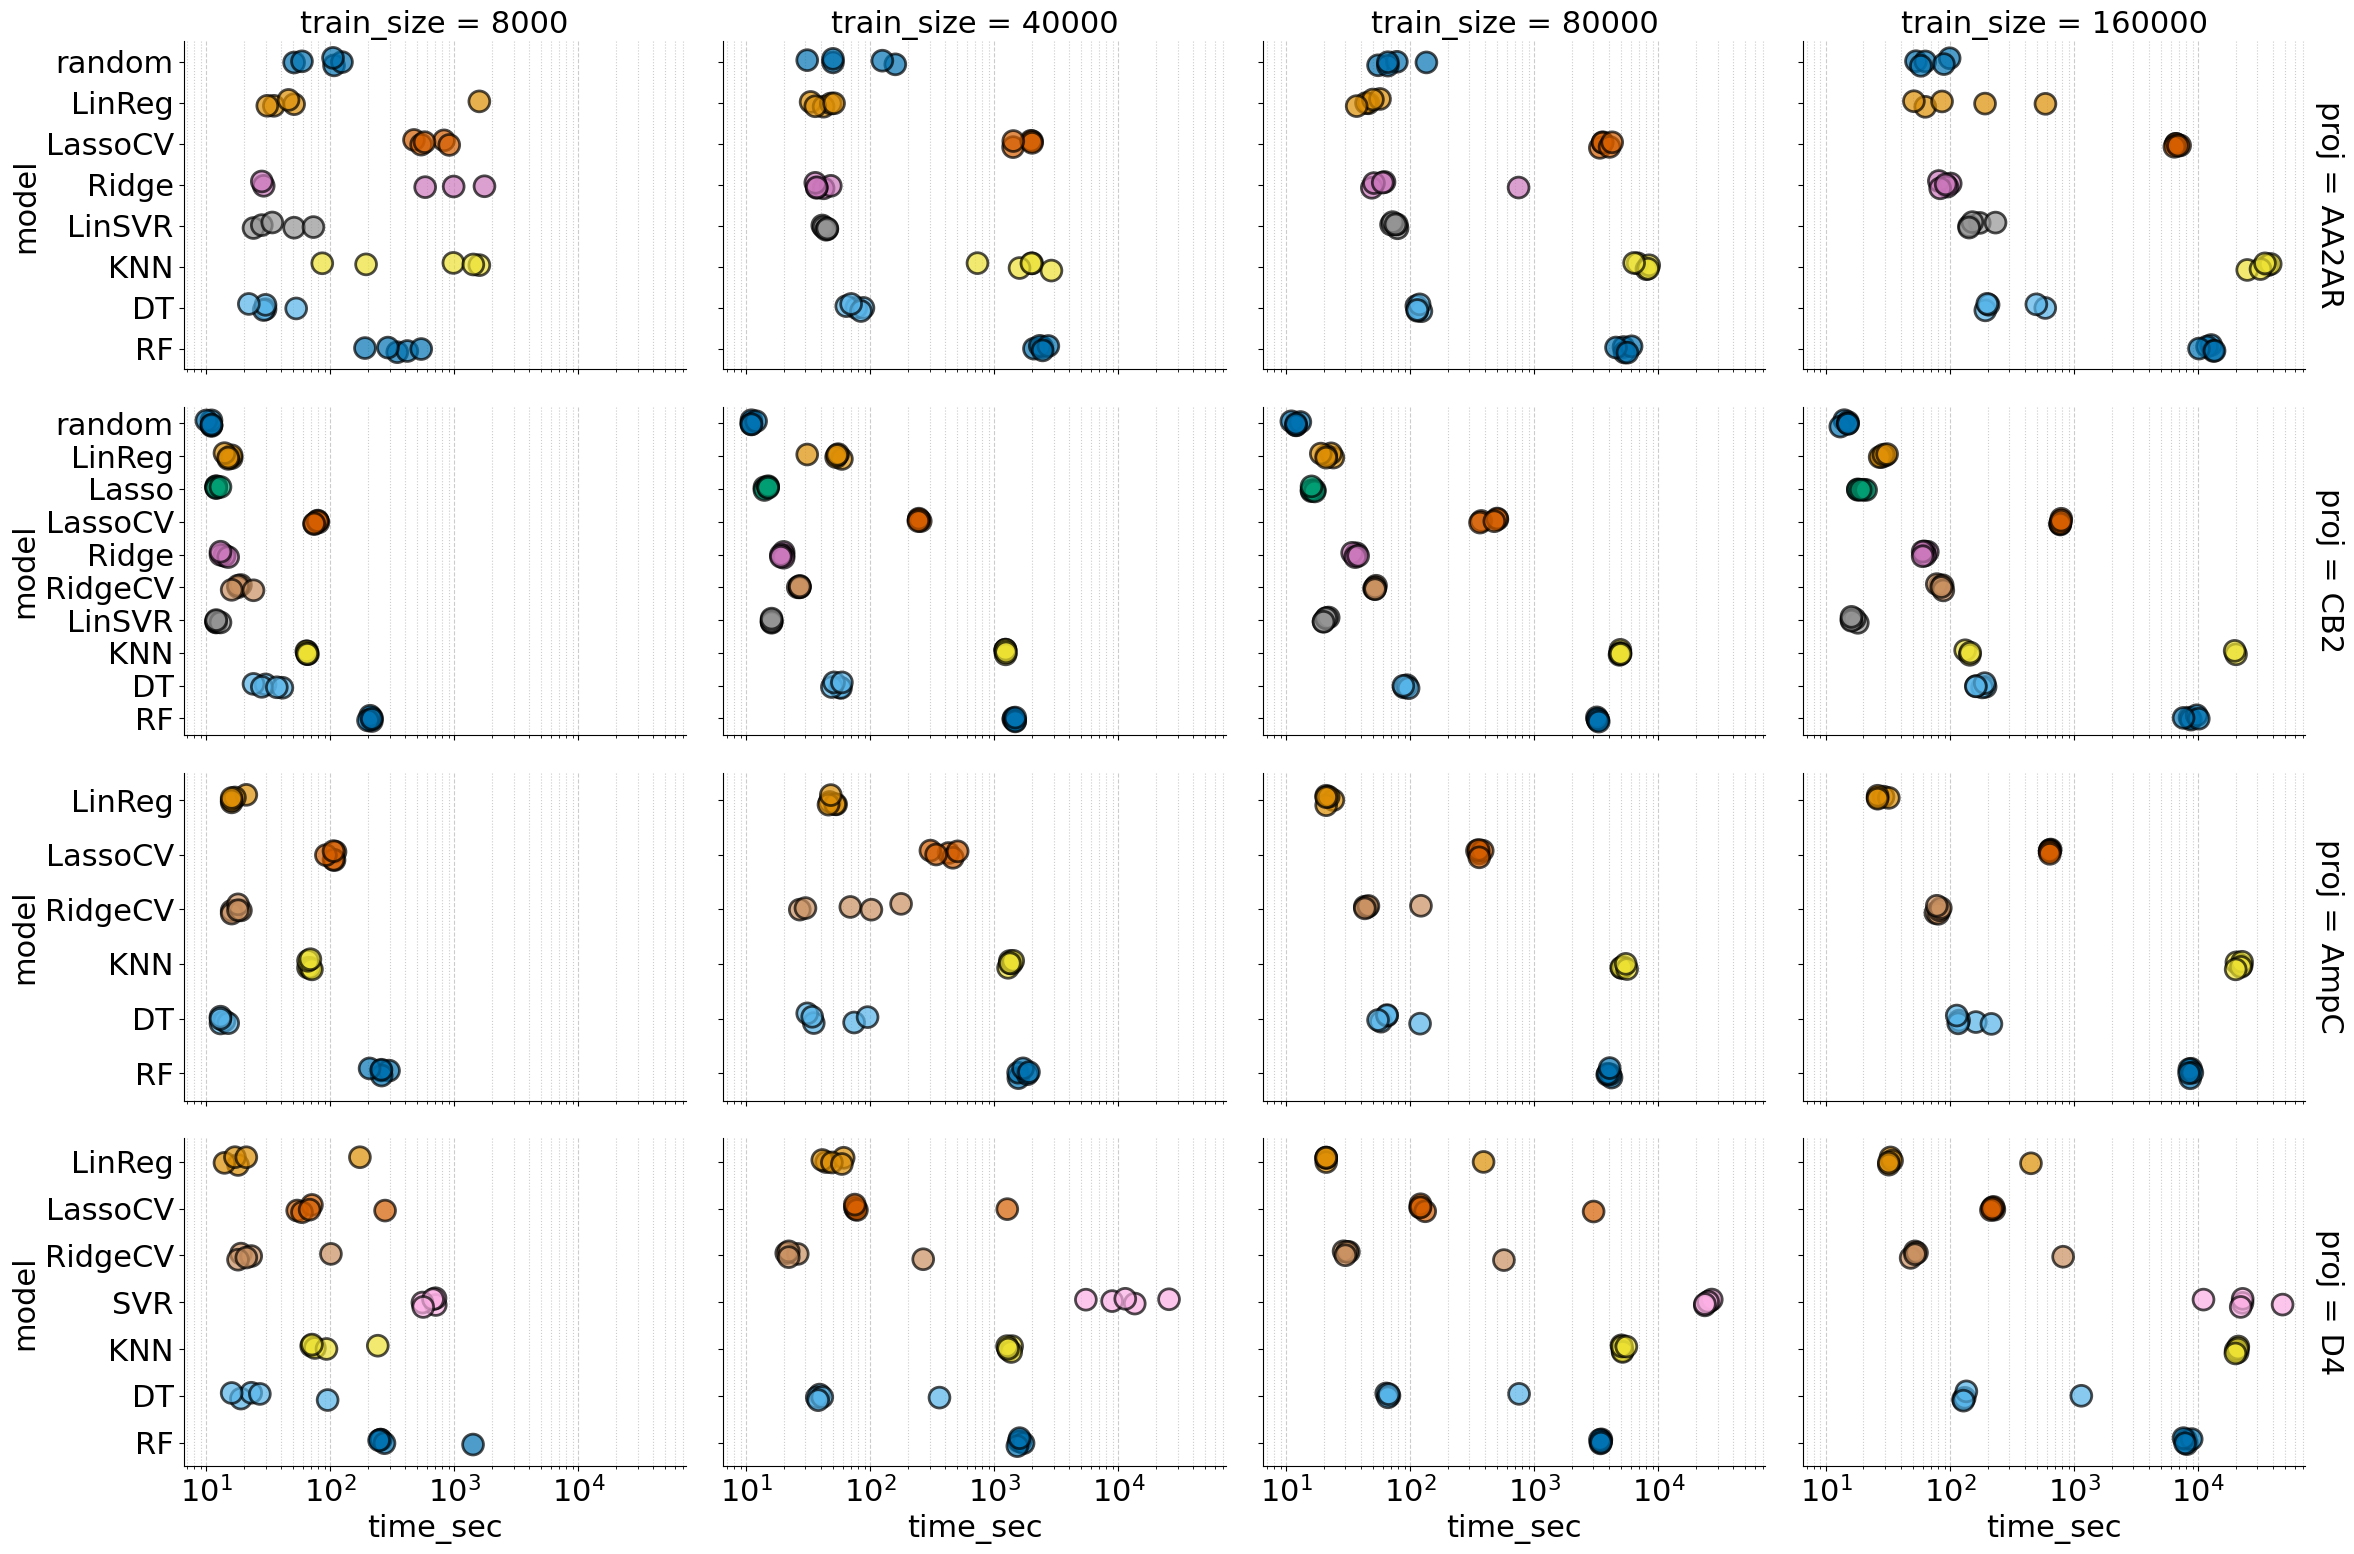

In [34]:
grid = sns.FacetGrid(
    data=df_p,
    col="train_size",
    row="proj",
    margin_titles=True,
    sharex=True,
    sharey="row",
    height=4,
    aspect=1.5,
    # row_order=row_order,
)

for ax in grid.axes.flat:
    ax.set_xscale('log', base=10)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
    ax.grid(which="major", color="#CCCCCC", linestyle="--")
    ax.grid(which="minor", color="#CCCCCC", linestyle=":")

# ----------------------
interesting_regressors = [rename.get(val) for val in interesting_regressors]
colors = sns.color_palette("colorblind", n_colors=len(interesting_regressors))
palette = {tag: color for tag, color in zip(interesting_regressors, colors)}
custom_order = {
    k: [
        model
        for model in interesting_regressors
        if model in df_p.query(f'proj=="{k}"').model.unique()
    ]
    for k in row_order
}

kwa = {
    "x": "time_sec",
    "y": "model",
    "edgecolor": "k",
    "linewidth": 2,
    "palette": palette,
    "s": 15,
    "alpha": 0.7,
    "order": custom_order,
}


grid.map_dataframe(
    ordered_stripplot,
    **kwa,
)
# grid.map_dataframe(
#    sns.stripplot,
#    **kwa,
# )

fout = "../figures/Figure_4_execution_time.png"
print(f"Saved figure to {fout=}")
plt.savefig(fout)